In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

2024-09-04 02:24:38.338928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# IMPORT DAN PARSING DATA #

In [4]:
# Load data
data = pd.read_csv('Dataset1.csv', parse_dates=['Tanggal'], dayfirst=True)

In [5]:
# STANDARISASI FORMAT #

In [6]:
numeric_cols = ['Pembukaan', 'Tertinggi', 'Terendah', 'Terakhir']
for col in numeric_cols:
    data[col] = data[col].str.replace(',', '.').astype(float)

In [7]:
# Mengganti tanda koma dengan titik dalam kolom Vol.
data['Vol.'] = data['Vol.'].str.replace(',', '').str.replace('M', '').astype(float) * 1e6

# Mengonversi kolom Change% menjadi desimal
data['Perubahan%'] = data['Perubahan%'].str.replace(',', '.').str.replace('%', '').astype(float) / 100

In [8]:
# Preprocess data
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal', inplace=True)

In [9]:
data = data.sort_values('Tanggal')

In [10]:
# DATA IMPUTATION #

In [11]:
df_unsampled = data.resample('D').asfreq().interpolate(method='linear')
df_unsampled.reset_index(inplace=True)
df_unsampled = df_unsampled.sort_values('Tanggal')

In [12]:
# SELEKSTI FITUR DAN WINDOWING#

In [13]:
# Pilih fitur
temp_X = df_unsampled.copy()
temp_y = df_unsampled.copy()
X = temp_X[['Pembukaan', 'Tertinggi', 'Terendah']].iloc[:-1,:]
y = temp_y['Terakhir'].shift(-1).dropna()

In [14]:
y= pd.DataFrame(y)

In [15]:
# DATA SPLITTING #

In [16]:
# Copy data untuk pelatihan dan pengujian
X_train = X.copy()
y_train = y.copy()

X_test = X.copy()
y_test = y.copy()

In [17]:
# Bagi data menjadi data pelatihan dan data pengujian
X_train = X_train.drop(X_train[2993:].index)
y_train = y_train.drop(y_train[2993:].index)

In [18]:
X_test = X_test.drop(X_test[:-749].index)
y_test = y_test.drop(y_test[:-749].index)

In [19]:
X_train2 = X_train.copy()
y_train2 = y_train.copy()

X_test2 = X_test.copy()
y_test2 = y_test.copy()

In [20]:
# DATA SCALING #

In [21]:
# Normalisasi data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train2 = scaler_X.fit_transform(X_train2)
X_test2 = scaler_X.transform(X_test2)
y_train2 = scaler_y.fit_transform(y_train2)
y_test2 = scaler_y.transform(y_test2)

In [22]:
n_val = int(0.2 * len(X_train2))  # 20% dari jumlah data pelatihan

# Mengambil 20% data terakhir untuk validasi
X_val_split = X_train2[-n_val:]
y_val_split = y_train2[-n_val:]

In [23]:
# Function to create dataset with given time step
def create_dataset(dataset_X, dataset_y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X) - time_step):
        dataX.append(dataset_X[i:(i + time_step), :])
        dataY.append(dataset_y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train2, y_train2 = create_dataset(X_train2, y_train2,time_step)
X_test2, y_test2 = create_dataset(X_test2, y_test2,time_step)
X_val_split, y_val_split = create_dataset(X_val_split, y_val_split, time_step)

In [24]:
# Reshape input to be [samples, time steps, features]
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], X_train2.shape[2])
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], X_test2.shape[2])
X_val_split = X_val_split.reshape(X_val_split.shape[0], X_val_split.shape[1],X_val_split.shape[2])

In [25]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=(X_train2.shape[1], X_train2.shape[2])))  # Menambahkan Input layer sebagai layer pertama
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile model using SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error')

In [26]:
# Train model
history = model.fit(X_train2, y_train2, epochs=50, validation_split=0.2, verbose=2)

Epoch 1/50
75/75 - 6s - 77ms/step - loss: 0.0227 - val_loss: 0.1452
Epoch 2/50
75/75 - 1s - 19ms/step - loss: 0.0076 - val_loss: 0.0409
Epoch 3/50
75/75 - 1s - 19ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 4/50
75/75 - 1s - 18ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 5/50
75/75 - 1s - 19ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/50
75/75 - 1s - 16ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 7/50
75/75 - 1s - 17ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/50
75/75 - 1s - 17ms/step - loss: 9.8950e-04 - val_loss: 0.0021
Epoch 9/50
75/75 - 1s - 16ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/50
75/75 - 1s - 17ms/step - loss: 9.6748e-04 - val_loss: 0.0024
Epoch 11/50
75/75 - 1s - 16ms/step - loss: 9.9997e-04 - val_loss: 0.0020
Epoch 12/50
75/75 - 1s - 16ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 13/50
75/75 - 1s - 17ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 14/50
75/75 - 1s - 17ms/step - loss: 9.7844e-04 - val_loss: 0.0021
Epoch 15/50
75/75 - 1s - 17

In [27]:
val_pred = model.predict(X_val_split)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [28]:
mse_val = mean_squared_error(y_val_split, val_pred)
r2_val = r2_score(y_val_split, val_pred)
mape_val = mean_absolute_percentage_error(y_val_split, val_pred)

In [29]:
print(f'MSE pada data validasi: {mse_val}')
print(f'R-squared pada data validasi: {r2_val}')
print(f'MAPE pada data validasi: {mape_val}')

MSE pada data validasi: 0.0013316452371901315
R-squared pada data validasi: 0.7347931840792419
MAPE pada data validasi: 0.036829794579398056


In [30]:
# Make predictions
y_pred = model.predict(X_test2)

# Evaluate the model
mse = mean_squared_error(y_test2, y_pred)
print(f'MSE: {mse}')

# Calculate R-Squared
r2 = r2_score(y_test2, y_pred)
print(f'R-Squared: {r2}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test2, y_pred)
print(f'MAPE: {mape}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.0019492974968662688
R-Squared: 0.8675315879447937
MAPE: 0.041336208129524904


In [31]:
# Visualisasi dan Dokumentasi

In [32]:
y_pred = scaler_y.inverse_transform(y_pred)

In [33]:
y_test2 = scaler_y.inverse_transform(y_test2)

In [34]:
y_pred = pd.DataFrame(y_pred, columns=['Prediksi'])

In [35]:
df_pred = df_unsampled.drop(['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%'], axis=1)
df_pred = df_pred.iloc[1:]
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred.drop(df_pred[:-749].index)

In [36]:
df_pred = df_pred['Tanggal'].reset_index()

In [37]:
preds = pd.concat([df_pred, y_pred], axis=1)
preds = preds.drop(['index'], axis=1)

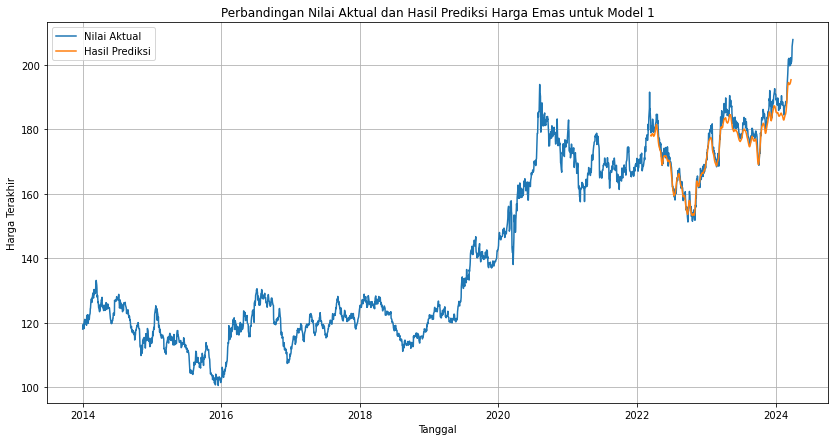

In [38]:
import seaborn as sns
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df_unsampled['Tanggal']), df_unsampled['Terakhir'], label='Nilai Aktual')
plt.plot(pd.to_datetime(preds['Tanggal']),preds['Prediksi'], label='Hasil Prediksi', linestyle='-') # Use 'Prediksi Harga' instead of 'y_pred'
plt.xlabel('Tanggal')
plt.ylabel('Harga Terakhir')
plt.title('Perbandingan Nilai Aktual dan Hasil Prediksi Harga Emas untuk Model 1')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Buat dataset untuk prediksi seluruh data
X_full = scaler_X.transform(X)
y_full = scaler_y.transform(y)

X_full, y_full = create_dataset(X_full, y_full, time_step)
X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], X_full.shape[2])

# Make predictions on full dataset
y_pred_full = model.predict(X_full)

# Inverse transform predictions
y_pred_full = scaler_y.inverse_transform(y_pred_full)

# Simpan hasil prediksi ke dalam CSV
predictions = pd.DataFrame(y_pred_full, columns=['Predicted_Terakhir'])
predictions.to_csv('predicted_Terakhir_LSTM.csv', index=False)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
